In [63]:
import os, sys
import glob
PARENT_FOLDER = os.path.join(os.path.dirname(os.path.realpath("__file__")), "../")
sys.path.append(PARENT_FOLDER)

import pandas as pd
import numpy as np
import matplotlib
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
from sklearn.linear_model import ElasticNetCV, ElasticNet
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose as sdc
from sklearn.preprocessing import StandardScaler,MinMaxScaler

%matplotlib inline

from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [4]:
font = {'weight' : 'normal',
        'family': 'Roboto',
        'size'   : 10}

sns.set(font_scale=1.6)
sns.set_style("white")

matplotlib.rc('font', **font)
pylab.rcParams['figure.figsize'] = (12, 9)

pd.options.display.float_format = "{:,.2f}".format

## Getting standard mc2 classification throughout the year

In [5]:
df = pd.read_pickle("../Data/V_all.pkl")

In [6]:
prod = pd.read_csv('../Data/product_snowflake.csv')

In [7]:
df_prod = df.merge(prod,left_on='item',right_on='part_number',how='inner')

In [8]:
df = df_prod.copy()

In [9]:
df.drop(['mc2','Unnamed: 0','part_number','snapshot_date'],1,inplace=True)

In [10]:
df = df.rename(columns={'merch_classification2':'mc2'})

In [11]:
df.isna().sum()

date                          0
item                          0
brand                         0
instock_views                 0
oos_views                     0
instock_conversions           0
oos_conversions               0
instock_quantity       16625077
oos_quantity            1586751
instock_price          16625077
oos_price               1586751
mc2                        2409
dtype: int64

In [12]:
# Eliminating mc2 null values. Filling null values with 0 for the rest, because those means there was no conversion
df = df[~df['mc2'].isna()]
df.fillna(0,inplace=True)

## Data by mc2

In [13]:
# Get the sum of the views and conversions per date per mc2
data_per_mc2 = df.groupby(['date','mc2'],as_index=False).agg({'instock_views':'sum','oos_views':'sum','instock_conversions':'sum','oos_conversions':'sum'})

In [14]:
# Get total PDP page views per mc2 and conversions purchase per week per mc2
data_per_mc2['total_views_mc2'] = data_per_mc2['instock_views'] + data_per_mc2['oos_views'] 
data_per_mc2['conversions_purchase_mc2'] = data_per_mc2['instock_conversions'] + data_per_mc2['oos_conversions'] 

In [15]:
data_per_mc21 = data_per_mc2.set_index(pd.to_datetime(data_per_mc2['date']))
data_per_mc21.index = data_per_mc21.index.to_period('W')

In [16]:
# Get the sum of total views and conversions per week per mc2
data_per_mc21 = data_per_mc21.groupby([data_per_mc21.index,'mc2']).agg({'date':'first','total_views_mc2':'sum','conversions_purchase_mc2':'sum'})

In [17]:
# Reset index
data_per_mc21.reset_index(level=1,inplace=True)

In [18]:
# Get conversion purchase rate per mc2
data_per_mc21['conv_purc_mc2_rate'] = data_per_mc21['conversions_purchase_mc2']/data_per_mc21['total_views_mc2']

In [19]:
df.shape

(54974781, 12)

In [20]:
data_per_mc21.shape

(4533, 5)

## Data all mc2 combined

In [21]:
# Get the sum of the views and conversions per week
data_all = df.groupby('date',as_index=False).agg({'instock_views':'sum','oos_views':'sum','instock_conversions':'sum','oos_conversions':'sum'})

In [22]:
# Get total PDP page views per mc2 and conversions purchase per week
data_all['total_views'] = data_all['instock_views'] + data_all['oos_views'] 
data_all['conversions_purchase'] = data_all['instock_conversions'] + data_all['oos_conversions'] 

In [23]:
data_all1 = data_all.set_index(pd.to_datetime(data_all['date']))
data_all1.index = data_all1.index.to_period('W')

In [24]:
data_all1 = data_all1.groupby(data_all1.index).agg({'date':'first','total_views':'sum','conversions_purchase':'sum'})

In [25]:
data_all1['conv_purc_rate'] = data_all1['conversions_purchase']/data_all1['total_views']

## Data per mc2 with features from all mc2 combined

In [26]:
data_combined = data_per_mc21.merge(data_all1,left_index=True,right_index=True,how='left')

In [27]:
# Get conversion purchase rate to all mc2 combined and percentage of total PDP page views per mc2 from the total of all mc2 combined
data_combined['conv_purc_rate_to_all'] = data_combined['conversions_purchase_mc2']/data_combined['total_views']
data_combined['total_views_perc'] = data_combined['total_views_mc2']/data_combined['total_views']

In [28]:
# Remove last week of data, as it is missing days of the week. Also remove the week 09/09/19-09/15/19 due to OOS rate outlier
data_combined_w = data_combined[(data_combined.index<'2021-07-05')&(data_combined.index!='2019-09-09/2019-09-15')] 

In [29]:
data_combined_w.head(3)

,mc2,date_x,total_views_mc2,conversions_purchase_mc2,conv_purc_mc2_rate,date_y,total_views,conversions_purchase,conv_purc_rate,conv_purc_rate_to_all,total_views_perc
date,,,,,,,,,,,
2018-01-01/2018-01-07,Apparel & People Products,2018-01-01,1809774,151569,0.08,2018-01-01,9735765,1767979,0.18,0.02,0.19
2018-01-01/2018-01-07,Beds & Furniture,2018-01-01,2464,260,0.11,2018-01-01,9735765,1767979,0.18,0.00,0.00
2018-01-01/2018-01-07,Chicken & Farm,2018-01-01,2014,243,0.12,2018-01-01,9735765,1767979,0.18,0.00,0.00


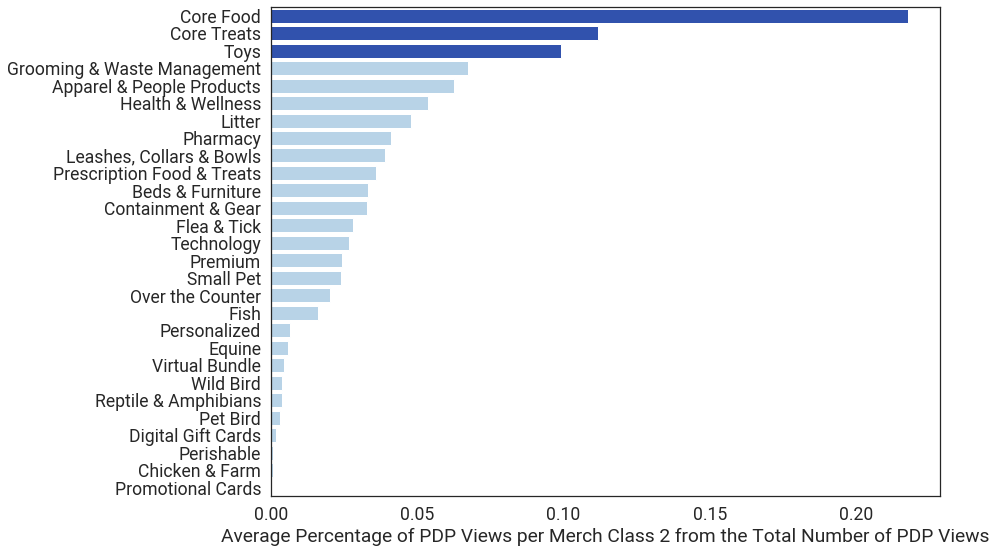

In [30]:
my_pal = {mc2: "#1C49C2" if (mc2 == "Core Food") | (mc2 == "Toys") | (mc2 == "Core Treats")\
          else "#B0D4EF" for mc2 in data_combined_w.mc2.unique()}

sns.barplot(y = 'mc2', x = 'total_views_perc', 
            data = data_combined_w.groupby('mc2',as_index=False).agg({'total_views_perc':'mean'}).sort_values(by='total_views_perc',ascending=False),
            palette=my_pal)

plt.xlabel('Average Percentage of PDP Views per Merch Class 2 from the Total Number of PDP Views')
plt.ylabel('')

plt.show()

## Datasets to get oos rate, ordered quantity and total price per oder

In [32]:
# Dataset containing oos rate
dfo = pd.read_csv('../Data/dfo_all.csv')

In [33]:
dfo_all = dfo.copy()
dfo_all = dfo_all.set_index(pd.to_datetime(dfo_all['date_trunc']))
dfo_all.index = dfo_all.index.to_period('W')

In [34]:
dfo_all.drop('date_trunc',1,inplace=True)

In [35]:
# Dataset containing ordered quantity and total price per order 
oredered_all = pd.read_csv('../Data/oredered_all.csv')

In [36]:
nUnitsOrdered_all = oredered_all.copy()
nUnitsOrdered_all = nUnitsOrdered_all.set_index(pd.to_datetime(nUnitsOrdered_all['date_trunc']))
nUnitsOrdered_all.index = nUnitsOrdered_all.index.to_period('W')

In [37]:
nUnitsOrdered_all = nUnitsOrdered_all.rename(columns={'product_merch_classification2':'mc2'})

## Dataset of total sessions

In [38]:
sessions_m = pd.read_csv('../Data/sessions.csv')

In [39]:
sessions_m['date'] = pd.to_datetime(sessions_m['date'])

In [40]:
sessions_m = sessions_m.set_index(pd.to_datetime(sessions_m['date']))
sessions_m.index = sessions_m.index.to_period('W')

In [41]:
sessions_m.drop(['date','Unnamed: 0'],1,inplace=True)

# MC2s from products database for iteration

In [42]:
mc2_unique = pd.read_csv('../Data/product_snowflake.csv')

# OOS rate x total purchase price for all MC2s combined

In [43]:
data_combined_w = data_combined_w.set_index(pd.to_datetime(data_combined_w['date_x']))
data_combined_w.index = data_combined_w.index.to_period('W')

In [44]:
data_combined_wM = data_combined_w.merge(dfo_all[['mc2','oos_rate']],left_on=[data_combined_w.index,'mc2'],right_on=[dfo_all.index,'mc2'],how='inner')

In [45]:
data_combined_wM = data_combined_wM.set_index(data_combined_wM['key_0'])

In [46]:
data_combined_wM.drop('key_0',1,inplace=True)

In [47]:
data_combined_wM = data_combined_wM.merge(nUnitsOrdered_all[['mc2', 'total_price',
                                                           'ordered_qty', 
                                                           'autoship_qty']],
                                    left_on=[data_combined_wM.index,'mc2'],right_on=[nUnitsOrdered_all.index,'mc2'],how='inner')

In [48]:
data_combined_wM['conv_order_mc2_rate'] = data_combined_wM['ordered_qty']/data_combined_wM['total_views_mc2']

In [49]:
data_combined_wMM = data_combined_wM.merge(sessions_m,left_on=['key_0','mc2'],right_on=['date','mc2'],how='inner')
data_combined_wMM['lagged_oos_rate'] = data_combined_wMM['oos_rate'].shift(-1)

In [50]:
data_combined_wMM.dropna(inplace=True)

In [51]:
data_combined_wMM.head(3)

,key_0,mc2,date_x,total_views_mc2,conversions_purchase_mc2,conv_purc_mc2_rate,date_y,total_views,conversions_purchase,conv_purc_rate,...,total_views_perc,oos_rate,total_price,ordered_qty,autoship_qty,conv_order_mc2_rate,total_visits_mc2,total_visits_all,total_visits_exc,lagged_oos_rate
0,2018-01-01/2018-01-07,Apparel & People Products,2018-01-01,1809774,151569,0.08,2018-01-01,9735765,1767979,0.18,...,0.19,0.05,"731,408.08","37,176.00","4,351.00",0.02,51417992,545189014,435598673,0.04
1,2018-01-01/2018-01-07,Core Food,2018-01-01,2483221,541810,0.22,2018-01-01,9735765,1767979,0.18,...,0.26,0.04,"26,450,986.33","1,005,980.00","599,085.00",0.41,109590341,545189014,435598673,0.04
2,2018-01-01/2018-01-07,Core Treats,2018-01-01,1316353,406145,0.31,2018-01-01,9735765,1767979,0.18,...,0.14,0.04,"6,124,753.72","839,462.00","387,836.00",0.64,81454263,545189014,435598673,0.01


In [52]:
data_combined_wMM.describe().T

,count,mean,std,min,25%,50%,75%,max
total_views_mc2,"3,420.00","684,363.76","724,934.97",933.00,"212,429.25","387,582.50","936,479.25","6,327,251.00"
conversions_purchase_mc2,"3,420.00","127,913.16","181,999.30",36.00,"20,351.50","56,409.50","147,631.00","1,979,145.00"
conv_purc_mc2_rate,"3,420.00",0.15,0.07,0.03,0.10,0.15,0.20,0.41
total_views,"3,420.00","14,104,482.79","5,130,327.36","7,308,861.00","9,465,086.00","11,445,953.00","18,554,898.00","28,403,481.00"
conversions_purchase,"3,420.00","2,609,575.47","1,007,005.48","1,301,024.00","1,656,188.00","2,203,561.00","3,383,449.00","5,748,618.00"
conv_purc_rate,"3,420.00",0.18,0.01,0.16,0.18,0.18,0.19,0.25
conv_purc_rate_to_all,"3,420.00",0.01,0.01,0.00,0.00,0.00,0.01,0.10
total_views_perc,"3,420.00",0.05,0.05,0.00,0.02,0.03,0.07,0.31
oos_rate,"3,420.00",0.05,0.06,0.00,0.02,0.04,0.07,0.55
total_price,"3,420.00","5,493,008.69","11,158,061.22","11,089.08","445,340.05","1,685,910.06","4,901,818.08","87,836,505.33"


In [53]:
data_combined_wMM_G = data_combined_wMM.groupby('key_0').agg({'total_price':'sum','oos_rate':'mean'})

In [54]:
# Total Purchase Price (Sales) per mc2 for FY2020

data_combined_wM[(data_combined_wM['key_0']>='03/02/2020')&(data_combined_wM['key_0']<='01/31/2021')].groupby('mc2',as_index=False).\
agg({'total_price':'sum'}).sort_values(by='total_price',ascending=False)

,mc2,total_price
4,Core Food,"2,853,827,265.63"
18,Prescription Food & Treats,"814,685,668.30"
5,Core Treats,"732,852,912.75"
12,Litter,"375,709,694.78"
10,Health & Wellness,"311,921,785.42"
17,Premium,"311,440,915.02"
22,Toys,"186,671,439.18"
8,Flea & Tick,"179,851,661.41"
1,Beds & Furniture,"149,250,817.24"
9,Grooming & Waste Management,"147,931,814.10"


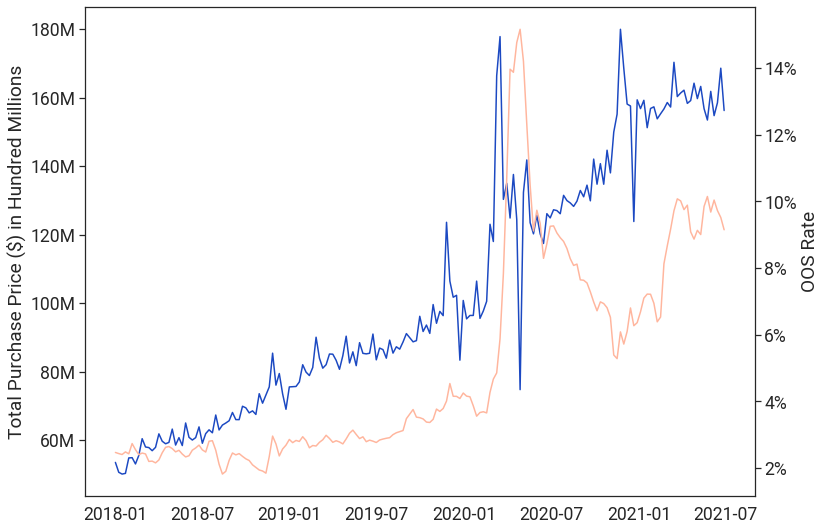

In [55]:
g = sns.lineplot(x =  data_combined_wMM_G.index.start_time, y = 'total_price', 
             data = data_combined_wMM_G,color='#1C49C2')
ax = plt.twinx(g)
p = sns.lineplot(x =  data_combined_wMM_G.index.start_time, y = 'oos_rate', 
             data = data_combined_wMM_G,color='#FFB69E',ax=ax)

p.set_ylabel('OOS Rate')
ylabels_oos = ['{:,.0f}'.format(y) + '%' for y in p.get_yticks()*100]
p.set_yticklabels(ylabels_oos)

g.set_xlabel('')
g.set_ylabel('Total Purchase Price ($) in Hundred Millions')
ylabels = ['{:,.0f}'.format(y) + 'M' for y in g.get_yticks()/10e5]
g.set_yticklabels(ylabels)

g.set_frame_on(False)

plt.show()

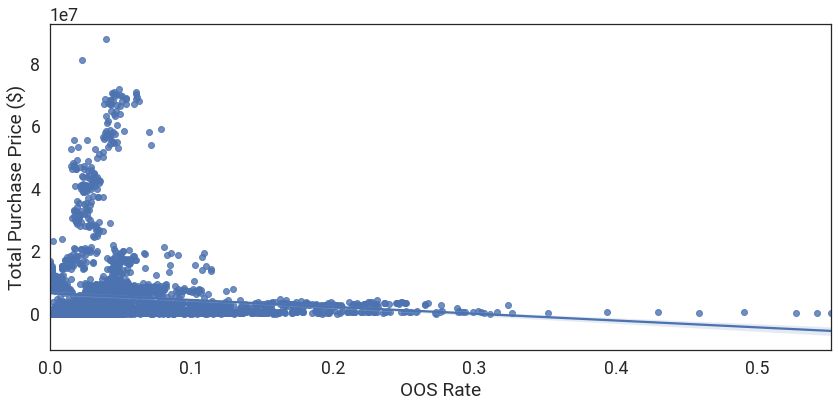

In [56]:
fig = plt.figure(figsize=(14, 6))

sns.regplot(x =  'oos_rate', y = 'total_price', data = data_combined_wMM)
plt.ylabel('Total Purchase Price ($)')
plt.xlabel('OOS Rate')

plt.show()

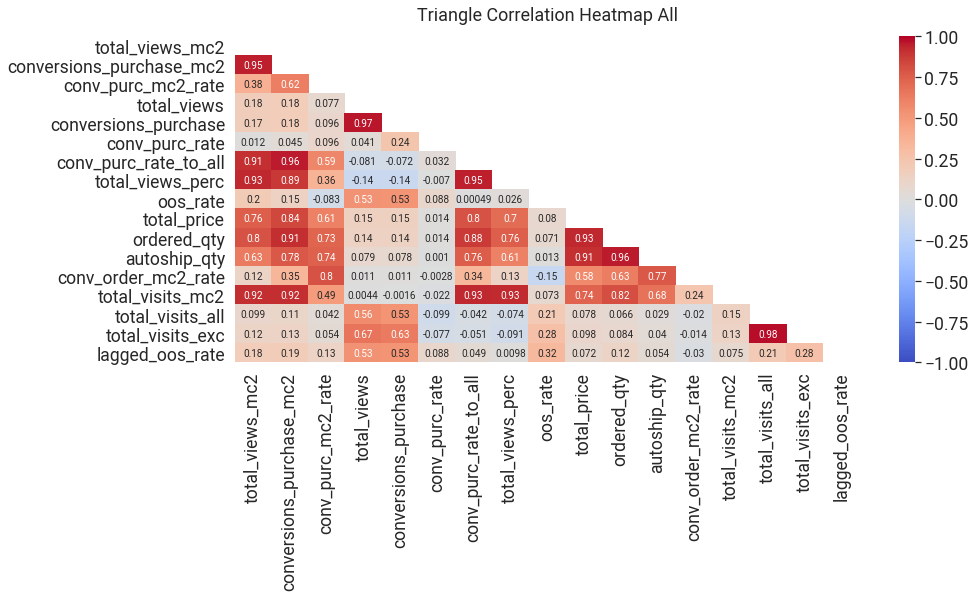

In [57]:
# Correlation Matrix Except MC2

corr = data_combined_wMM.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm')

fig = plt.figure(figsize=(14, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap {}'.format('All'), fontdict={'fontsize':18}, pad=16)

plt.savefig('../Summary Results/images_v1/corr_{}.jpg'.format('All'),bbox_inches='tight')

# Correlations and feature importance per mc2

In [59]:
def getData(mc2, period='full period'):
    if period == 'before':
        df_exc = data_combined_w[(data_combined_w['mc2']!= mc2)&(data_combined_w.index < '2020-01-01')]
        df = data_combined_w[(data_combined_w['mc2']== mc2)&(data_combined_w.index < '2020-01-01')]
    elif period == 'after':                              
        df_exc = data_combined_w[(data_combined_w['mc2']!= mc2)&(data_combined_w.index >= '2020-01-01')]
        df = data_combined_w[(data_combined_w['mc2']== mc2)&(data_combined_w.index >= '2020-01-01')]
    elif period == 'full period':                              
        df_exc = data_combined_w[(data_combined_w['mc2']!= mc2)]
        df = data_combined_w[(data_combined_w['mc2']== mc2)]
    
    df_exc = df_exc.set_index(pd.to_datetime(df_exc['date_x']))
    df_exc.index = df_exc.index.to_period('W')
    
    df = df.set_index(pd.to_datetime(df['date_x']))
    df.index = df.index.to_period('W')
    
    df_excM = df_exc.merge(dfo_all[['mc2','oos_rate']],left_on=[df_exc.index,'mc2'],right_on=[dfo_all.index,'mc2'],how='inner')
    df_M = df.merge(dfo_all[['mc2','oos_rate']],left_on=[df.index,'mc2'],right_on=[dfo_all.index,'mc2'],how='inner')
    
    df_excM = df_excM.set_index(df_excM['key_0'])
    df_M = df_M.set_index(df_M['key_0'])
    
    df_excM.drop('key_0',1,inplace=True)
    df_M.drop('key_0',1,inplace=True)
    
    df_excM = df_excM.merge(nUnitsOrdered_all[['mc2', 'total_price',
                                                           'ordered_qty', 
                                                           'autoship_qty']],
                                    left_on=[df_excM.index,'mc2'],right_on=[nUnitsOrdered_all.index,'mc2'],how='inner')
    df_M = df_M.merge(nUnitsOrdered_all[['mc2', 'total_price',
                                                           'ordered_qty', 
                                                           'autoship_qty']],
                              left_on=[df_M.index,'mc2'],right_on=[nUnitsOrdered_all.index,'mc2'],how='inner') 
    
    df_excM['conv_order_mc2_rate'] = df_excM['ordered_qty']/df_excM['total_views_mc2']
    df_M['conv_order_mc2_rate'] = df_M['ordered_qty']/df_M['total_views_mc2']
    
    df_MM = df_M.merge(sessions_m,left_on=['key_0','mc2'],right_on=['date','mc2'],how='inner')
    df_excMM = df_excM.merge(sessions_m,left_on=['key_0','mc2'],right_on=['date','mc2'],how='inner')
    
    df_MM['lagged_oos_rate'] = df_MM['oos_rate'].shift(-1)
    df_excMM['lagged_oos_rate'] = df_excMM['oos_rate'].shift(-1)
    
    df_MM.dropna(inplace=True)
    df_excMM.dropna(inplace=True)
    
    df_excMM.to_csv('../data_v1/df_{}.jpg'.format(file))
    df_MM.to_csv('../data_v1/df_{}.jpg'.format(file))
    
    return df_excMM, df_MM

In [85]:
def ks_teste(df, df_exc):
    return stats.ks_2samp(df_exc['total_price'],df['total_price'])

def convOOStimeseries(df,period='full period'):
    fig = plt.figure(figsize=(14, 6))

    ax = sns.lineplot(x='date_x',y='conv_purc_mc2_rate',data=df,label='Purchase Conversion Rate per MC2')
    ax1 = plt.twinx(ax)
    sns.lineplot(x='date_x',y='oos_rate',data=df,color='r',ax=ax1,label='OOS Rate')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(bbox_to_anchor=(1.05, 0.85), loc='upper left')
    ax.set_ylabel('Conversion Rate')
    ax1.set_ylabel('OOS Rate')
    ax.set_xlabel('')
    plt.title('Conversion Rate x OOS Rates', fontsize=18)

    plt.savefig('../Summary Results/images_v1/cvsXoos_{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)

def generateFig(df,df_exc,period='full period'):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.lineplot(x =  'date_x', y = 'total_price', data = df)
    ax1 = plt.twinx(ax)
    sns.lineplot(x =  'date_x', y = 'oos_rate', data = df,color='r',ax=ax1)
    
    plt.savefig('../Summary Results/images_v1/Time Series/time_series_{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)
    
    
    # Correlation Matrix Except MC2

    corr_exc = df_exc.corr(method="spearman")
    corr_exc.style.background_gradient(cmap='coolwarm')

    fig = plt.figure(figsize=(14, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(corr_exc, dtype=np.bool))
    heatmap = sns.heatmap(corr_exc, mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    heatmap.set_title('Triangle Correlation Heatmap {}'.format('All Except {}'.format(mc2)), fontdict={'fontsize':18}, pad=16)
    
    plt.savefig('../Summary Results/images_v1/Correlations/except_mc2/corr_exc{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)
    
    # Correlation Matrix MC2

    corr = df.corr(method="spearman")
    corr.style.background_gradient(cmap='coolwarm')

    fig = plt.figure(figsize=(14, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    heatmap.set_title('Triangle Correlation Heatmap {}'.format(mc2), fontdict={'fontsize':18}, pad=16)

    plt.savefig('../Summary Results/images_v1/Correlations/mc2/corr_{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)
    
    return corr['total_price']['oos_rate'], corr['total_price']['lagged_oos_rate'],corr_exc['total_price']['oos_rate'], corr_exc['total_price']['lagged_oos_rate']

def generateScatter(df,df_exc,period='full period'):
    fig = plt.figure(figsize=(14, 6))
    sns.regplot(x='oos_rate',y='total_price',data=df)
    
    plt.ylabel('Total Purchase Price ($)')
    plt.xlabel('OOS Rate')
    
    plt.savefig('../Summary Results/images_v1/Correlations/mc2/scatter_{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)
    
def lrOOSConversionRate(mc2,df):
    modls = []
    
    model = sfm.ols('conv_purc_mc2_rate ~ oos_rate',data=df).fit()
        
    r_sqr = model.rsquared

    intercept = model.params[0]

    coef = intercept = model.params[1]

    t_oos = model.tvalues[1]

    p_oos = model.pvalues[1]

    modls.append([mc2,r_sqr,intercept,coef,t_oos,p_oos])
    
    return modls

def runElasticNet(df,period='full period',how=None):
    X = df.dropna().drop(['total_price','key_0', 'mc2', 'date_x','date_y','ordered_qty','autoship_qty'],1)
    Y = df.dropna()['total_price']
    if how == 'standard':
        scaler = StandardScaler()
        scaler.fit(X,Y)
        X_scaled = scaler.transform(X)
        cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
    
        cv_model.fit((X_scaled),Y)

        model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
        model.fit(X_scaled,Y)
        
        r2 = r2_score(df['total_price'],model.predict(X_scaled))
    elif how == 'minmax':
        scaler = MinMaxScaler()
        scaler.fit(X,Y)
        X_scaled = scaler.transform(X)
        cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
    
        cv_model.fit((X_scaled),Y)

        model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
        model.fit(X_scaled,Y)
        r2 = r2_score(df['total_price'],model.predict(X_scaled))
    else:
        cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')
    
        cv_model.fit(X,Y)

        model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
        model.fit(X,Y)
        r2 = r2_score(df['total_price'],model.predict(X))
    
    feature_importance = pd.Series(index = df.dropna().drop(['total_price','key_0', 'mc2', 'date_x','date_y',
                                                                                                    'ordered_qty','autoship_qty'],1).columns, 
                               data = model.coef_)
    lis = []
    
    n_selected_features = (np.abs(feature_importance)>0).sum()
    
    fig = plt.figure()

    np.abs(feature_importance).sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
    
    plt.savefig('../Summary Results/images_v1/Feature Importance/featureImportance_{}_{}.jpg'.format(file,period),bbox_inches='tight')
    
    plt.close(fig)
    
    lis.append([mc2,feature_importance,r2,n_selected_features,(1-n_selected_features/len(feature_importance))*100])
    
    return lis

# Considering full period (2018 - 2021)

In [86]:
features = pd.DataFrame()
r = pd.DataFrame()
rOOSConv = pd.DataFrame()
for mc2 in mc2_unique['merch_classification2'].unique():
    try:
        print('Started ',mc2)
        period='full period'
        file = mc2.replace('&','').replace(',','')
        df_excMM, df_MM = getData(mc2)
        generateScatter(df_MM,df_excMM)
        convOOStimeseries(df_MM)
        stat, pvalue = ks_teste(df_MM, df_excMM)
        corr_oos, corr_lag_oos, corr_exc_oos, corr_exc_lag_oos = generateFig(df_MM, df_excMM)
        lis = runElasticNet(df_MM, how='minmax')
        modls = lrOOSConversionRate(mc2,df_MM)
        rOOSConv = pd.concat([rOOSConv,pd.DataFrame(modls)])
        features = pd.concat([features,pd.DataFrame(lis)])
        r = pd.concat([r,pd.DataFrame([[mc2,corr_oos, corr_lag_oos, corr_exc_oos, corr_exc_lag_oos]])])
        print('End')
    except:
        continue

Started  Core Treats
End
Started  Core Food
End
Started  Prescription Food & Treats
End
Started  Premium
End
Started  Health & Wellness
End
Started  Toys
End
Started  Containment & Gear
End
Started  Beds & Furniture
End
Started  Leashes, Collars & Bowls
End
Started  Grooming & Waste Management
End
Started  Technology
End
Started  Litter
End
Started  Over the Counter
End
Started  Apparel & People Products
End
Started  Flea & Tick
End
Started  nan
Started  Fish
End
Started  Reptile & Amphibians
End
Started  Pet Bird
End
Started  Small Pet
End
Started  Wild Bird
End
Started  Perishable
End
Started  Equine
End
Started  Pharmacy


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Chicken & Farm
End
Started  Personalized
End
Started  Virtual Bundle


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Digital Gift Cards


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Promotional Cards


No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [87]:
r.columns = ['mc2','corr_oos', 'corr_lag_oos', 'corr_exc_mc2_oos', 'corr_exc_mc2_lag_oos']
r.reset_index(inplace=True,drop=True)

In [88]:
rOOSConv.columns = ['mc2','r_sqr','intercept','coef','t_oos','p_oos']
rOOSConv.reset_index(inplace=True,drop=True)

In [89]:
rOOSConv.to_csv('../Summary Results/output/summary_convXoos_full_period.csv')

In [90]:
r.to_csv('../Summary Results/output/summary_correlations_full_period.csv')

In [92]:
# Get frequencies of most important features

new_df = features.reset_index(drop=True).merge(pd.DataFrame(features[1].to_list()),left_index=True,right_index=True,how='inner')
new_df = new_df.drop(1,1).rename(columns={0:'mc2',2:'r2',3:'n_features_selected',4:'perc_reduction_features'})

feat_df = pd.melt(new_df, id_vars=['mc2','r2','n_features_selected','perc_reduction_features'], 
                  value_vars=new_df.drop(['mc2','r2','n_features_selected','perc_reduction_features'],1).columns, ignore_index=False)
feat_df.reset_index(inplace=True,drop=True)

feat_df['feature_importance'] = np.abs(feat_df['value'])
feat_df = feat_df.rename(columns={'variable':'feature','value':'coeff'})

feat_df.to_csv('../Summary Results/summary_elasticNet_full_period.csv')

feat_g = feat_df.groupby(['mc2','feature']).agg({'feature_importance':'max'})

top_feat = feat_g.sort_values(by=['mc2','feature_importance'])[~feat_g.index.get_level_values(0).duplicated(keep='last')]

top_feat.groupby('feature').count()

,feature_importance
feature,
conv_order_mc2_rate,9
conversions_purchase_mc2,7
lagged_oos_rate,1
total_views,1
total_views_mc2,5
total_visits_mc2,1


Text(0, 0.5, 'Feature')

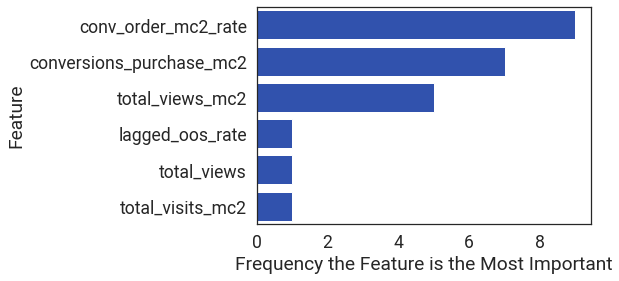

In [93]:
sns.barplot(y = top_feat.groupby('feature').count().sort_values(by='feature_importance',ascending=False).index, 
            x = top_feat.groupby('feature').count().sort_values(by='feature_importance',ascending=False)['feature_importance'],
           color = '#1C49C2')

plt.xlabel('Frequency the Feature is the Most Important')
plt.ylabel('Feature')

# Considering 2018-2019

In [98]:
features_before = pd.DataFrame()
r_before = pd.DataFrame()
rOOSConv_before = pd.DataFrame()
for mc2 in mc2_unique['merch_classification2'].unique():
    try:
        print('Started ',mc2)
        period='before'
        file = mc2.replace('&','').replace(',','')
        df_excMM_before, df_MM_before = getData(mc2,period=period)
        convOOStimeseries(df_MM_before,period=period)
        stat_before, pvalue_before = ks_teste(df_MM_before, df_excMM_before)
        corr_oos_before, corr_lag_oos_before, corr_exc_oos_before, corr_exc_lag_oos_before = generateFig(df_MM_before, df_excMM_before,period=period)
        modls_before = lrOOSConversionRate(mc2,df_MM_before)
        rOOSConv_before = pd.concat([rOOSConv_before,pd.DataFrame(modls_before)])
        lis_before = runElasticNet(df_MM_before, how='minmax',period=period)
        features_before = pd.concat([features_before,pd.DataFrame(lis_before)])
        r_before = pd.concat([r_before,pd.DataFrame([[mc2,corr_oos_before, corr_lag_oos_before, corr_exc_oos_before, corr_exc_lag_oos_before]])])
        print('End')
    except:
        continue

Started  Core Treats
End
Started  Core Food
End
Started  Prescription Food & Treats
End
Started  Premium
End
Started  Health & Wellness
End
Started  Toys


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Containment & Gear


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Beds & Furniture


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Leashes, Collars & Bowls
Started  Grooming & Waste Management
End
Started  Technology
End
Started  Litter
End
Started  Over the Counter
End
Started  Apparel & People Products
End
Started  Flea & Tick
End
Started  nan
Started  Fish


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Reptile & Amphibians


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Pet Bird
Started  Small Pet
End
Started  Wild Bird


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Perishable
Started  Equine


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Pharmacy


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Chicken & Farm
Started  Personalized


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Virtual Bundle


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Digital Gift Cards


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Promotional Cards


In [99]:
r_before.columns = ['mc2','corr_oos', 'corr_lag_oos', 'corr_exc_mc2_oos', 'corr_exc_mc2_lag_oos']
r_before.reset_index(inplace=True,drop=True)

In [100]:
rOOSConv_before.columns = ['mc2','r_sqr','intercept','coef','t_oos','p_oos']
rOOSConv_before.reset_index(inplace=True,drop=True)

In [101]:
rOOSConv_before.to_csv('../Summary Results/output/summary_convXoos_before.csv')

In [102]:
r_before.to_csv('../Summary Results/output/summary_correlations_before.csv')

In [103]:
new_df_before = features_before.reset_index(drop=True).merge(pd.DataFrame(features_before[1].to_list()),left_index=True,right_index=True,how='inner')
new_df_before = new_df_before.drop(1,1).rename(columns={0:'mc2',2:'r2',3:'n_features_selected',4:'perc_reduction_features'})

feat_df_before = pd.melt(new_df_before, id_vars=['mc2','r2','n_features_selected','perc_reduction_features'], 
                  value_vars=new_df_before.drop(['mc2','r2','n_features_selected','perc_reduction_features'],1).columns, ignore_index=False)
feat_df_before.reset_index(inplace=True,drop=True)

feat_df_before['feature_importance'] = np.abs(feat_df_before['value'])
feat_df_before = feat_df_before.rename(columns={'variable':'feature','value':'coeff'})

feat_df_before.to_csv('../Summary Results/summary_elasticNet_before.csv')

feat_g_before = feat_df_before.groupby(['mc2','feature']).agg({'feature_importance':'max'})

top_feat_before = feat_g_before.sort_values(by=['mc2','feature_importance'])[~feat_g_before.index.get_level_values(0).duplicated(keep='last')]

top_feat_before.groupby('feature').count()

,feature_importance
feature,
conv_order_mc2_rate,7
conv_purc_mc2_rate,1
conversions_purchase_mc2,4
total_views,1
total_views_mc2,4


Text(0, 0.5, 'Feature')

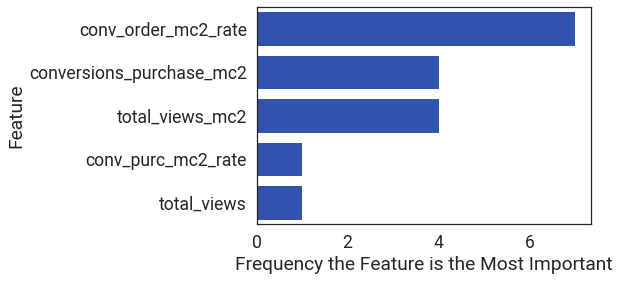

In [104]:
sns.barplot(y = top_feat_before.groupby('feature').count().sort_values(by='feature_importance',ascending=False).index, 
            x = top_feat_before.groupby('feature').count().sort_values(by='feature_importance',ascending=False)['feature_importance'],
           color = '#1C49C2')

plt.xlabel('Frequency the Feature is the Most Important')
plt.ylabel('Feature')

# Considering 2020 on

In [106]:
features_after = pd.DataFrame()
r_after = pd.DataFrame()
rOOSConv_after = pd.DataFrame()
for mc2 in mc2_unique['merch_classification2'].unique():
    try:
        print('Started ',mc2)
        period='after'
        file = mc2.replace('&','').replace(',','')
        df_excMM_after, df_MM_after = getData(mc2,period=period)
        convOOStimeseries(df_MM_after,period=period)
        stat_after, pvalue_after = ks_teste(df_MM_after, df_excMM_after)
        corr_oos_after, corr_lag_oos_after, corr_exc_oos_after, corr_exc_lag_oos_after = generateFig(df_MM_after, df_excMM_after,period=period)
        modls_after = lrOOSConversionRate(mc2,df_MM_after)
        rOOSConv_after = pd.concat([rOOSConv_after,pd.DataFrame(modls_after)])
        lis_after = runElasticNet(df_MM_after, how='minmax',period=period)
        features_after = pd.concat([features_after,pd.DataFrame(lis_after)])
        r_after = pd.concat([r_after,pd.DataFrame([[mc2,corr_oos_after, corr_lag_oos_after, corr_exc_oos_after, corr_exc_lag_oos_after]])])
        print('End')
    except:
        continue

Started  Core Treats
End
Started  Core Food
End
Started  Prescription Food & Treats
End
Started  Premium
End
Started  Health & Wellness
End
Started  Toys
End
Started  Containment & Gear
End
Started  Beds & Furniture
End
Started  Leashes, Collars & Bowls
End
Started  Grooming & Waste Management
End
Started  Technology
End
Started  Litter
End
Started  Over the Counter
End
Started  Apparel & People Products
End
Started  Flea & Tick
End
Started  nan
Started  Fish
End
Started  Reptile & Amphibians
End
Started  Pet Bird
End
Started  Small Pet
End
Started  Wild Bird
End
Started  Perishable
End
Started  Equine


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Pharmacy
Started  Chicken & Farm
End
Started  Personalized


No handles with labels found to put in legend.
No handles with labels found to put in legend.


End
Started  Virtual Bundle


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Digital Gift Cards


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Started  Promotional Cards


In [107]:
r_after.columns = ['mc2','corr_oos', 'corr_lag_oos', 'corr_exc_mc2_oos', 'corr_exc_mc2_lag_oos']
r_after.reset_index(inplace=True,drop=True)

In [108]:
rOOSConv_after.columns = ['mc2','r_sqr','intercept','coef','t_oos','p_oos']
rOOSConv_after.reset_index(inplace=True,drop=True)

In [109]:
rOOSConv_after.to_csv('../Summary Results/output/summary_convXoos_after.csv')

In [110]:
r_after.to_csv('../Summary Results/output/summary_correlations_after.csv')

In [111]:
new_df_after = features_after.reset_index(drop=True).merge(pd.DataFrame(features_after[1].to_list()),left_index=True,right_index=True,how='inner')
new_df_after = new_df_after.drop(1,1).rename(columns={0:'mc2',2:'r2',3:'n_features_selected',4:'perc_reduction_features'})

feat_df_after = pd.melt(new_df_after, id_vars=['mc2','r2','n_features_selected','perc_reduction_features'], 
                  value_vars=new_df.drop(['mc2','r2','n_features_selected','perc_reduction_features'],1).columns, ignore_index=False)
feat_df_after.reset_index(inplace=True,drop=True)

feat_df_after['feature_importance'] = np.abs(feat_df_after['value'])
feat_df_after = feat_df_after.rename(columns={'variable':'feature','value':'coeff'})

feat_df_after.to_csv('../Summary Results/summary_elasticNet_after.csv')

feat_g_after = feat_df_after.groupby(['mc2','feature']).agg({'feature_importance':'max'})

top_feat_after = feat_g_after.sort_values(by=['mc2','feature_importance'])[~feat_g_after.index.get_level_values(0).duplicated(keep='last')]

top_feat_after.groupby('feature').count()

,feature_importance
feature,
conv_order_mc2_rate,10
conversions_purchase_mc2,5
lagged_oos_rate,1
total_views_mc2,4
total_views_perc,1
total_visits_exc,1
total_visits_mc2,2


Text(0, 0.5, 'Feature')

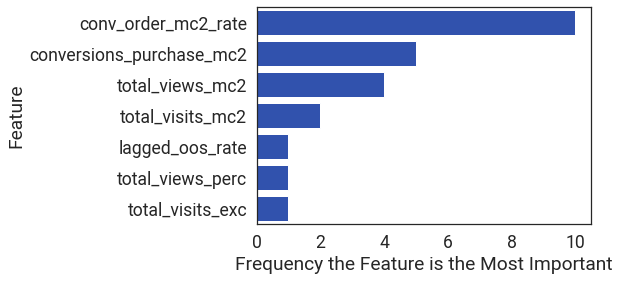

In [112]:
sns.barplot(y = top_feat_after.groupby('feature').count().sort_values(by='feature_importance',ascending=False).index, 
            x = top_feat_after.groupby('feature').count().sort_values(by='feature_importance',ascending=False)['feature_importance'],
           color = '#1C49C2')

plt.xlabel('Frequency the Feature is the Most Important')
plt.ylabel('Feature')